In [49]:
import warnings
warnings.filterwarnings("ignore")
import os
import ta
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import spearmanr
from sklearn.model_selection import TimeSeriesSplit,train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from joblib import Parallel, delayed
from rich.progress import track, Progress
from pykalman import KalmanFilter
from math import log, fabs
import ta.volatility as volatility
from sklearn.metrics import mutual_info_score

In [50]:
currency_pairs = ['NZDUSD', 'SP500', 'GBPUSD', 'AUDCAD', 'USDNOK', 'AUDUSD', 'AUDJPY', 'STOXX50E', 'USDCAD', 'USDSGD', 'USDSEK', 'EURUSD']

In [51]:
def SMA_diff(df, col, n, m):

    df[f"SMA_d_{n}"] = ta.trend.SMAIndicator(df[col], int(n)).sma_indicator()
    df[f"SMA_d_{m}"] = ta.trend.SMAIndicator(df[col], int(m)).sma_indicator()

    df[f"SMA_diff"] = df[f"SMA_d_{n}"] - df[f"SMA_d_{m}"]
    return df


def RSI_diff(df, col, n, m):

    df[f"RSI_{n}"] = ta.momentum.RSIIndicator(df[col], int(n)).rsi()
    df[f"RSI_{m}"] = ta.momentum.RSIIndicator(df[col], int(m)).rsi()

    df[f"RSI_diff"] = df[f"RSI_{n}"] - df[f"RSI_{m}"]

    return df

def SMA(df, col, n):
    
    df[f'SMA_{n}'] = df[col].rolling(window=n).mean()
    
    return df

def EMA(df, col, n):
    
    df[f'EMA_{n}'] = df[col].ewm(span=n, adjust=False).mean()
    
    return df

def RSI(df, col, n):
    
    rsi_series = ta.momentum.RSIIndicator(df[col], int(n)).rsi()  
    df[f"RSI_{n}"] = rsi_series  
    
    return df

def smooth_RSI(df, col, n, ma_type='SMA', ma_period=10):
    rsi_series = ta.momentum.RSIIndicator(df[col], int(n)).rsi()  
    df[f"RSI_{n}"] = rsi_series  
    if ma_type == 'SMA':
        df[f"RSI_{n}_{ma_type}_{ma_period}"] = df[f"RSI_{n}"].rolling(window=ma_period).mean()
    elif ma_type == 'EMA':
        df[f"RSI_{n}_{ma_type}_{ma_period}"] = df[f"RSI_{n}"].ewm(span=ma_period, adjust=False).mean()
        
    return df

def STO_RSI(df, col, n):

    StoRsi = ta.momentum.StochRSIIndicator(df[col], int(n))
    
    df[f"STO_RSI_{n}"] = StoRsi.stochrsi() * 100
    df[f"STO_RSI_D_{n}"] = StoRsi.stochrsi_d() * 100
    df[f"STO_RSI_K_{n}"] = StoRsi.stochrsi_k() * 100
    
    return df

def ATR(df, n):
    
    df[f"ATR_{n}"] = ta.volatility.AverageTrueRange(df["high"], df["low"], df["close"], n).average_true_range()
    
    return df

def smooth_ATR(df, n, ma_type='SMA', ma_period=10):
    
    df[f"ATR_{n}"] = ta.volatility.AverageTrueRange(df["high"], df["low"], df["close"], n).average_true_range()
    if ma_type == 'SMA':
        df[f"ATR_{n}_{ma_type}_{ma_period}"] = df[f"ATR_{n}"].rolling(window=ma_period).mean()
    elif ma_type == 'EMA':
        df[f"ATR_{n}_{ma_type}_{ma_period}"] = df[f"ATR_{n}"].ewm(span=ma_period, adjust=False).mean()
        
    return df

def MACD(df, col, n_fast=12, n_slow=26, n_signal=9):

    #MACD
    macd_indicator = ta.trend.MACD(df[col],window_slow=n_slow,window_fast=n_fast,window_sign=n_signal)

    #MACD Columns
    df[f'MACD_{n_fast}_{n_slow}'] = macd_indicator.macd()
    df[f'MACD_signal_{n_signal}'] = macd_indicator.macd_signal()
    df[f'MACD_hi_{n_fast}_{n_slow}_{n_signal}'] = macd_indicator.macd_diff()

    return df

def smooth_MACD(df, col, n_fast=12, n_slow=26, n_signal=9, ma_type='SMA', ma_period=10):
    
    macd_indicator = ta.trend.MACD(df[col], window_slow=n_slow, window_fast=n_fast, window_sign=n_signal)
    df[f'MACD_{n_fast}_{n_slow}'] = macd_indicator.macd()
    df[f'MACD_signal_{n_signal}'] = macd_indicator.macd_signal()
    df[f'MACD_hi_{n_fast}_{n_slow}_{n_signal}'] = macd_indicator.macd_diff()
    
    # Suavizar el histograma MACD
    if ma_type == 'SMA':
        df[f'MACD_hi_{n_fast}_{n_slow}_{n_signal}_{ma_type}_{ma_period}'] = df[f'MACD_hi_{n_fast}_{n_slow}_{n_signal}'].rolling(window=ma_period).mean()
    elif ma_type == 'EMA':
        df[f'MACD_hi_{n_fast}_{n_slow}_{n_signal}_{ma_type}_{ma_period}'] = df[f'MACD_hi_{n_fast}_{n_slow}_{n_signal}'].ewm(span=ma_period, adjust=False).mean()
    
    return df

def STK(df, close_col, low_col, high_col, n):

    stoch = ta.momentum.StochasticOscillator(high=df[high_col], low=df[low_col], close=df[close_col], window=n, smooth_window=10)
    
    df[f'STK_{n}'] = stoch.stoch()

    return df

def rolling_std(df, col, n):
    
    df[f'std_{n}'] = df[col].rolling(window=n).std()
    
    return df


def RSI_lowess(df, col, n, frac=0.01):
    # RSI
    rsi_period = int(n)
    df['RSI'] = ta.momentum.RSIIndicator(df[col], window=rsi_period).rsi()

    df['RSI'].fillna(0, inplace=True)

    numerical_index = df.index.map(pd.Timestamp.timestamp)

    smoothed_rsi = lowess(df['RSI'], numerical_index, frac=frac, it=3)

    # RSI_Lowess
    df['RSI_lowess'] = smoothed_rsi[:, 1]

    return df
    
def CMMA(df, close_col, high_col, low_col, lookback, atr_length):

    n = len(df)
    output = np.zeros(n)
    front_bad = max(lookback, atr_length)

    for i in range(front_bad, n):
        # ATR
        tr = np.maximum(
            df[high_col].iloc[i - atr_length + 1:i + 1] - df[low_col].iloc[i - atr_length + 1:i + 1],
            np.abs(df[high_col].iloc[i - atr_length + 1:i + 1] - df[close_col].iloc[i - atr_length:i].shift(1)),
            np.abs(df[low_col].iloc[i - atr_length + 1:i + 1] - df[close_col].iloc[i - atr_length:i].shift(1))
        )
        atr = np.mean(tr)

        # LOG AVERAGE
        log_avg = np.mean(np.log(df[close_col].iloc[i - lookback:i]))

        if atr > 0:
            denom = atr * np.sqrt(lookback + 1)
            z_score = (np.log(df[close_col].iloc[i]) - log_avg) / denom
            output[i] = 100.0 * norm.cdf(z_score) - 50.0
        else:
            output[i] = 0.0

    df[f"CMMA_{lookback}"] = output

    return df

def kalman_filter(df, close_col, window=None):

    valores = df[close_col].values

    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)


    state_means, _ = kf.filter(valores)

    df[f"kalman_{close_col}"] = state_means

    if window:
        df[f"kalman_{close_col}_{window}"] = df[f"kalman_{close_col}"].rolling(window=window).mean()

    return df

def calculate_trend(df, close_col, high_col, low_col, lookback, atr_length, trend_type):
    n = len(df)
    output = np.zeros(n)
    front_bad = max(lookback, atr_length)

    # Legendre simulation
    if trend_type == 'linear':
        coefs = np.linspace(-1, 1, lookback)
        col_name = 'linear_trend'
    elif trend_type == 'quadratic':
        coefs = np.linspace(-1, 1, lookback)**2
        col_name = 'quad_trend'
    elif trend_type == 'cubic':
        coefs = np.linspace(-1, 1, lookback)**3
        col_name = 'cubic_trend'
    else:
        raise ValueError("Tren no valid 'linear', 'quadratic' o 'cubic'.")

    for icase in range(front_bad, n):
        # ATR (Average True Range)
        tr = np.maximum(
            df[high_col].iloc[icase - atr_length + 1:icase + 1] - df[low_col].iloc[icase - atr_length + 1:icase + 1],
            np.abs(df[high_col].iloc[icase - atr_length + 1:icase + 1] - df[close_col].iloc[icase - atr_length:icase].shift(1)),
            np.abs(df[low_col].iloc[icase - atr_length + 1:icase + 1] - df[close_col].iloc[icase - atr_length:icase].shift(1))
        )
        atr = np.mean(tr)

        # Log promedian
        log_prices = np.log(df[close_col].iloc[icase - lookback:icase])
        dot_prod = np.dot(log_prices, coefs)
        log_avg = np.mean(log_prices)

        if atr > 0:
            # Z-score based ATR
            denom = atr * np.sqrt(lookback + 1)
            z_score = (dot_prod - log_avg) / denom
            output[icase] = 100.0 * norm.cdf(z_score) - 50.0
        else:
            output[icase] = 0.0

    df[f"{col_name}_{lookback}"] = output
    return df

class Entropy:
    def __init__(self, wordlen):

        if wordlen < 1:
            self.ok = False
            self.bins = None
            return
        
        self.wordlen = wordlen
        self.nbins = 2 ** wordlen  # n bins ^wordlenght
        self.bins = np.zeros(self.nbins, dtype=int)  # bins initialilzed
        self.ok = True

    def entropy(self, nx, wordlen, x):

        if wordlen < 1 or nx <= wordlen:
            return 0.0

        # Init bins
        self.bins.fill(0)
        
        # Bins counting
        for i in range(wordlen, nx):
            k = 1 if x[i - 1] > x[i] else 0
            for j in range(1, wordlen):
                k *= 2
                if x[i - j - 1] > x[i - j]:
                    k += 1
            self.bins[k] += 1

        # Entropy
        ent = 0.0
        total_bins = nx - wordlen
        for i in range(self.nbins):
            p = self.bins[i] / total_bins
            if p > 0.0:
                ent -= p * np.log(p)

        # Norm entropy
        return ent / np.log(self.nbins)

def entropy_filter(df, close_col, wordlen, window=None):

    valores = df[close_col].values
    
    #Class Entropy
    entropy_instance = Entropy(wordlen)
    
    # Entropy for each point
    entropia = np.zeros(len(valores))
    for i in range(len(valores)):
        if i < wordlen:
            entropia[i] = 0  # First value no entropy
        else:
            entropia[i] = entropy_instance.entropy(i + 1, wordlen, valores[:i + 1][::-1])
    
    # Add column
    df[f"entropy_{close_col}"] = entropia
    
    # Promedian jic
    if window:
        df[f"entropy_{close_col}_{window}"] = df[f"entropy_{close_col}"].rolling(window=window).mean()
    
    return df


# PERCENTAGE PRICE OSCILLATOR (PPO)
def PPO(df, close_col, short_length, long_length, n_to_smooth=1):
    # Convert lengths to integers
    short_length = int(short_length + 0.5)
    long_length = int(long_length + 0.5)
    n_to_smooth = int(n_to_smooth + 0.5)
    
    # Initialize variables
    n = len(df)
    front_bad = long_length + n_to_smooth
    if front_bad > n:
        front_bad = n
    back_bad = 0
    
    long_alpha = 2.0 / (long_length + 1.0)
    short_alpha = 2.0 / (short_length + 1.0)
    
    long_sum = short_sum = df[close_col].iloc[0]
    output = np.zeros(n)
    output[0] = 0.0  # Poorly defined at first case
    
    # Compute PPO
    for icase in range(1, n):
        long_sum = long_alpha * df[close_col].iloc[icase] + (1.0 - long_alpha) * long_sum
        short_sum = short_alpha * df[close_col].iloc[icase] + (1.0 - short_alpha) * short_sum
        output[icase] = 100.0 * (short_sum - long_sum) / (long_sum + 1.e-15)  # Official PPO
        
        # Optional normalization (comment out if not needed)
        output[icase] = 100.0 * norm.cdf(0.2 * output[icase]) - 50.0
    
    # Smooth if requested
    if n_to_smooth > 1:
        alpha = 2.0 / (n_to_smooth + 1.0)
        smoothed = output[0]
        for icase in range(1, n):
            smoothed = alpha * output[icase] + (1.0 - alpha) * smoothed
            output[icase] -= smoothed
    
    # Store PPO result in DataFrame
    df[f"PPO_{short_length}_{long_length}"] = output
    
    return df
    
# PRICE CHANGE OSCILLATOR (PCO)
def PCO(df, close_col, param1, param2):
    # Columnas de precios
    close = df[close_col].values
    open_ = df['open'].values
    high = df['high'].values
    low = df['low'].values

    n = len(close)
    short_length = int(param1 + 0.5)
    mult = int(param2 + 0.5)
    if mult < 2:
        mult = 2
    long_length = short_length * mult  # Long lookback

    # Calcular ATR usando la librería ta y actualizar el DataFrame
    df['ATR'] = volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df[close_col], window=long_length).average_true_range()
    atr_values = df['ATR'].values

    # Inicializar valores
    front_bad = min(long_length, n)  # Número de valores indefinidos al inicio
    output = np.zeros(n)

    # Asignar valores neutros para los casos indefinidos al inicio
    output[:front_bad] = 0.0

    # Calcular el indicador para los casos restantes
    for icase in range(front_bad, n):
        short_sum = sum(fabs(log(close[k] / close[k - 1])) for k in range(icase - short_length + 1, icase + 1))

        long_sum = short_sum
        for k in range(icase - long_length + 1, icase - short_length + 1):
            long_sum += fabs(log(close[k] / close[k - 1]))

        short_sum /= short_length
        long_sum /= long_length

        denom = 0.36 + 1.0 / short_length  # Aproximación para mult = 2
        v = log(0.5 * mult) / 1.609  # Igual a 0 para mult = 2, 1 para mult = 10
        denom += 0.7 * v  # Corrección para multiplicadores entre 2 y 10
        denom *= atr_values[icase]

        if denom > 1.e-20:
            output[icase] = (short_sum - long_sum) / denom
            output[icase] = 100.0 * norm.cdf(4.0 * output[icase]) - 50.0
        else:
            output[icase] = 0.0

    # Crear columna en el DataFrame
    df[f'PCO_{close_col}'] = output

    return df

def future_returns(df, N):
    
    df_copy = df.copy()
    #df_copy["log_close"] = np.log(df_copy["close"])
    df_copy["log_close"] = df_copy["close"]
    df_copy[f"fut_ret_{N}"] = (df_copy["log_close"].shift(-N) - df_copy["log_close"]) / df_copy["log_close"]
    
    return df_copy.replace(0, 1e-10).dropna()
   
def process_currency_pair(pair):
    
    file_path = f"C:/Users/jlaho/Desktop/Quantreo/Quant/Data/FixTimeBars/D_{pair}_1h.csv"
    df = pd.read_csv(file_path, index_col="time", parse_dates=True)
    ruta_completa = os.path.abspath(file_path)
    
    # Imprimir la ruta completa para verificar
    print(f"Reading...: {ruta_completa}")
    
    start_date = df.index.min()
    end_date = start_date + pd.DateOffset(years=7)
    df = df[(df.index >= start_date) & (df.index < end_date)].copy()
    
    # Ensure only the first 7 years are selected
    start_date = df.index.min()
    end_date = start_date + pd.DateOffset(years=5)
    df = df[(df.index >= start_date) & (df.index < end_date)].copy()
    
    # Apply feature creation
    create_features(df)
    
    # Apply target
    df = future_returns(df, 10)

    # Create train asset using the first 5 years of the 7 years
    train_end_date = start_date + pd.DateOffset(years=4)
    train_asset = df[(df.index >= start_date) & (df.index < train_end_date)]
    
    return pair.lower(), df, train_asset

def main():
    processed_data = []  
    # Initialize progress tracker with rich
    progress = Progress()
    task = progress.add_task("[cyan]Processing currency pairs...", total=len(currency_pairs))
    
    with progress:
        # Parallel processing using joblib
        results = Parallel(n_jobs=-1)(delayed(process_currency_pair)(pair) for pair in currency_pairs)
        
        for result in results:
            processed_data.append(result)
            pair_lower, df, train_asset = result
            #print(f"Processed data for {pair_lower}: {df.shape}")
            #print(f"Processed train asset for {pair_lower}_train: {train_asset.shape}")
            progress.update(task, advance=1)

    return processed_data

FEATURE_CONFIG = {
    
    "SMA_diff": {"n": 30, "m": 120},
    "RSI": {"n": 14},
    "PPO": {"short_length": 12, "long_length": 26, "n_to_smooth": 9},
    "PCO": {"param1": 10, "param2": 2},
    "STO_RSI": {"n": 14},
    "ATR": {"n": 10},
    "MACD": {"n_fast": 12, "n_slow": 26, "n_signal": 9},
    "rolling_std": {"n": 10},
    "STK": {"n": 10},
    "CMMA": {"lookback": 10, "atr_length": 200},
    "kalman": {"window": 10},
    "calculate_trend": {"lookback": 10, "atr_length": 200, "trend_type": "linear"},
    "smooth_ATR": {"n": 14, "ma_type": "SMA", "ma_period": 10},
    "smooth_RSI": {"n": 14, "ma_type": "EMA", "ma_period": 10},
    "smooth_MACD": {"n_fast": 12, "n_slow": 26, "n_signal": 9,"ma_type": "EMA", "ma_period": 10}
    
}
def create_features(df):
    
    df = SMA_diff(df, "close", FEATURE_CONFIG["SMA_diff"]["n"], FEATURE_CONFIG["SMA_diff"]["m"])
    df = RSI(df, "close", FEATURE_CONFIG["RSI"]["n"])
    df = PPO(df, "close", **FEATURE_CONFIG["PPO"])
    df = PCO(df, "close", **FEATURE_CONFIG["PCO"])
    df = STO_RSI(df, "close", FEATURE_CONFIG["STO_RSI"]["n"])
    df = ATR(df, FEATURE_CONFIG["ATR"]["n"])
    df = MACD(df, "close", **FEATURE_CONFIG["MACD"])
    df = rolling_std(df, "close", FEATURE_CONFIG["rolling_std"]["n"])
    df = STK(df, "close", "low", "high", FEATURE_CONFIG["STK"]["n"])
    df = CMMA(df, "close", "high", "low", FEATURE_CONFIG["CMMA"]["lookback"], FEATURE_CONFIG["CMMA"]["atr_length"])
    df = kalman_filter(df, "close", window=FEATURE_CONFIG["kalman"]["window"])
    df = calculate_trend(df, "close", "high", "low", FEATURE_CONFIG["calculate_trend"]["lookback"], FEATURE_CONFIG["calculate_trend"]["atr_length"], FEATURE_CONFIG["calculate_trend"]["trend_type"])
    df = smooth_ATR(df, **FEATURE_CONFIG["smooth_ATR"])
    df = smooth_RSI(df, "close", **FEATURE_CONFIG["smooth_RSI"])
    df = smooth_MACD(df, "close", **FEATURE_CONFIG["smooth_MACD"])
    
    return df

if __name__ == "__main__":
    processed_data = main()
    
    dataframes = {}
    train_dataframes = {}

    for pair, df, train_asset in processed_data:
        dataframes[pair] = df
        train_dataframes[f"{pair}"] = train_asset


In [52]:
df = create_features(df)
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'high_time', 'low_time',
       'SMA_d_30', 'SMA_d_120', 'SMA_diff', 'RSI_14', 'PPO_12_26', 'ATR',
       'PCO_close', 'STO_RSI_14', 'STO_RSI_D_14', 'STO_RSI_K_14', 'ATR_10',
       'MACD_12_26', 'MACD_signal_9', 'MACD_hi_12_26_9', 'std_10', 'STK_10',
       'CMMA_10', 'kalman_close', 'kalman_close_10', 'linear_trend_10',
       'ATR_14', 'ATR_14_SMA_10', 'RSI_14_EMA_10', 'MACD_hi_12_26_9_EMA_10',
       'log_close', 'fut_ret_10'],
      dtype='object')


In [53]:
def drop_nans(dataframes, axis=0):
    for key, df in dataframes.items():
        dataframes[key] = df.dropna(axis=axis)

# Drop rows with any NaNs
drop_nans(dataframes, axis=0)
drop_nans(train_dataframes, axis=0)

In [54]:
list_X = [
    "SMA_diff",
    f"RSI_{FEATURE_CONFIG['RSI']['n']}",
    f"PPO_{FEATURE_CONFIG['PPO']['short_length']}_{FEATURE_CONFIG['PPO']['long_length']}",
    "PCO_close",
    f"STO_RSI_{FEATURE_CONFIG['STO_RSI']['n']}",
    f"STO_RSI_D_{FEATURE_CONFIG['STO_RSI']['n']}",
    f"STO_RSI_K_{FEATURE_CONFIG['STO_RSI']['n']}",
    f"ATR_{FEATURE_CONFIG['ATR']['n']}",
    f"MACD_{FEATURE_CONFIG['MACD']['n_fast']}_{FEATURE_CONFIG['MACD']['n_slow']}",
    f"MACD_signal_{FEATURE_CONFIG['MACD']['n_signal']}",
    f"MACD_hi_{FEATURE_CONFIG['MACD']['n_fast']}_{FEATURE_CONFIG['MACD']['n_slow']}_{FEATURE_CONFIG['MACD']['n_signal']}",
    f"std_{FEATURE_CONFIG['rolling_std']['n']}",
    f"STK_{FEATURE_CONFIG['STK']['n']}",
    f"CMMA_{FEATURE_CONFIG['CMMA']['lookback']}",
    f"kalman_close_{FEATURE_CONFIG['kalman']['window']}",
    f"{FEATURE_CONFIG['calculate_trend']['trend_type']}_trend_{FEATURE_CONFIG['calculate_trend']['lookback']}",
    f"ATR_{FEATURE_CONFIG['smooth_ATR']['n']}_{FEATURE_CONFIG['smooth_ATR']['ma_type']}_{FEATURE_CONFIG['smooth_ATR']['ma_period']}",
    f"RSI_{FEATURE_CONFIG['smooth_RSI']['n']}_{FEATURE_CONFIG['smooth_RSI']['ma_type']}_{FEATURE_CONFIG['smooth_RSI']['ma_period']}",
    f"MACD_hi_{FEATURE_CONFIG['smooth_MACD']['n_fast']}_{FEATURE_CONFIG['smooth_MACD']['n_slow']}_{FEATURE_CONFIG['smooth_MACD']['n_signal']}_{FEATURE_CONFIG['smooth_MACD']['ma_type']}_{FEATURE_CONFIG['smooth_MACD']['ma_period']}"
]

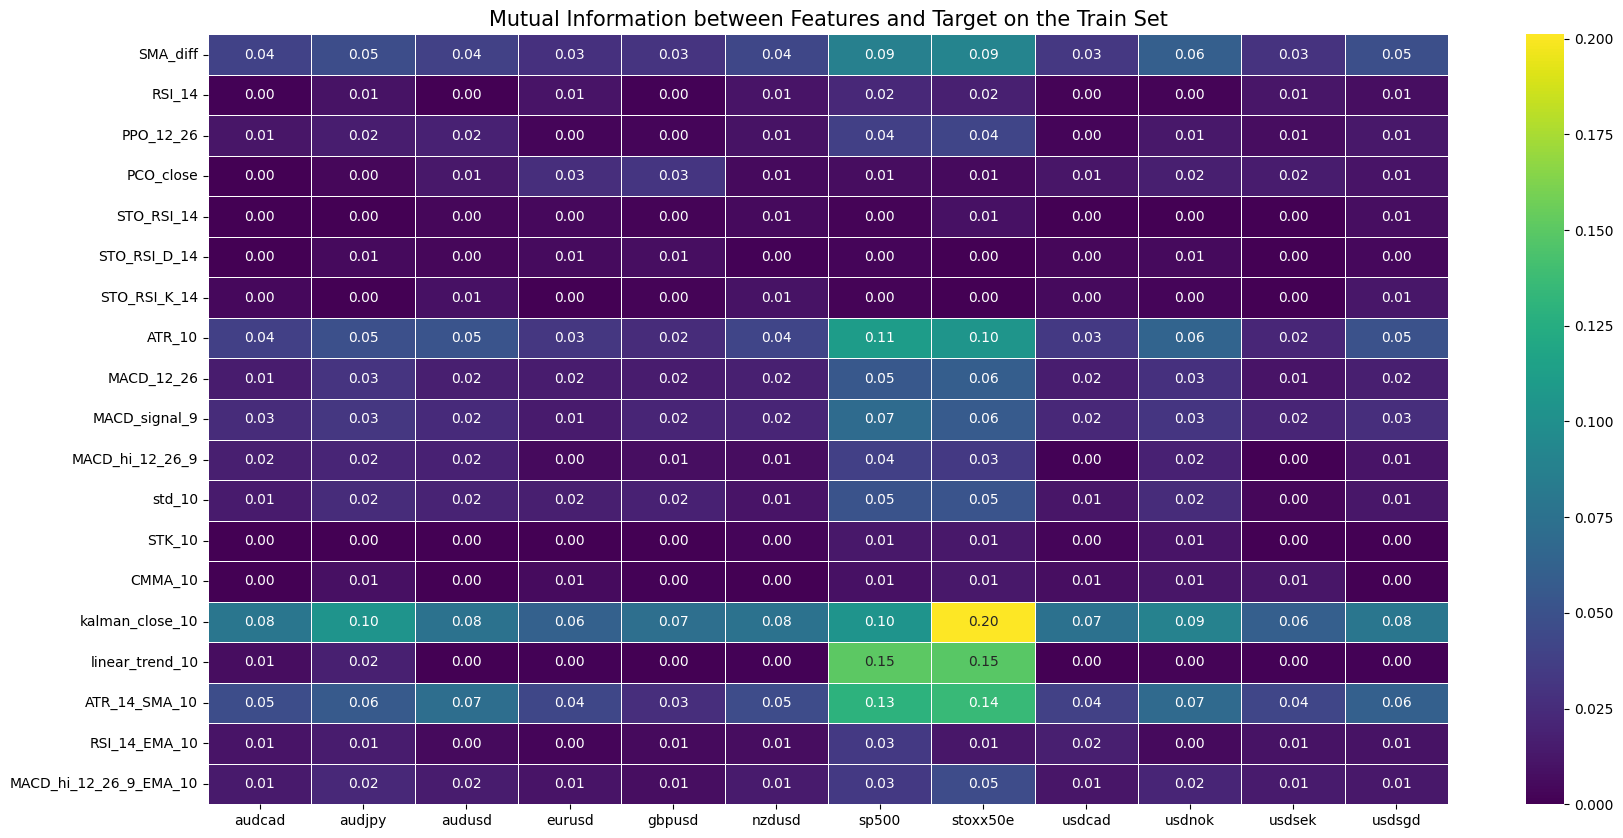

In [55]:
from sklearn.feature_selection import mutual_info_regression

col_y = 'fut_ret_10'
mutual_infos = []
ordered_keys = sorted(train_dataframes.keys())

for key in ordered_keys:
    df_copy = train_dataframes[key][list_X + [col_y]].dropna()
    
    X = df_copy[list_X].iloc[:-1, :]
    y = df_copy[col_y].iloc[1:]
    
    # Calcular información mutua
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)
    
    # Convertir en Series con nombres de features
    mi_series = pd.Series(mi, index=list_X)
    mutual_infos.append(mi_series)

# Crear DataFrame final
mutual_info_df = pd.concat(mutual_infos, axis=1)
mutual_info_df.columns = ordered_keys  # Cada columna = un key

# Plot
plt.figure(figsize=(20, 10))
sns.heatmap(mutual_info_df, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title("Mutual Information between Features and Target on the Train Set", size=15)
plt.show()

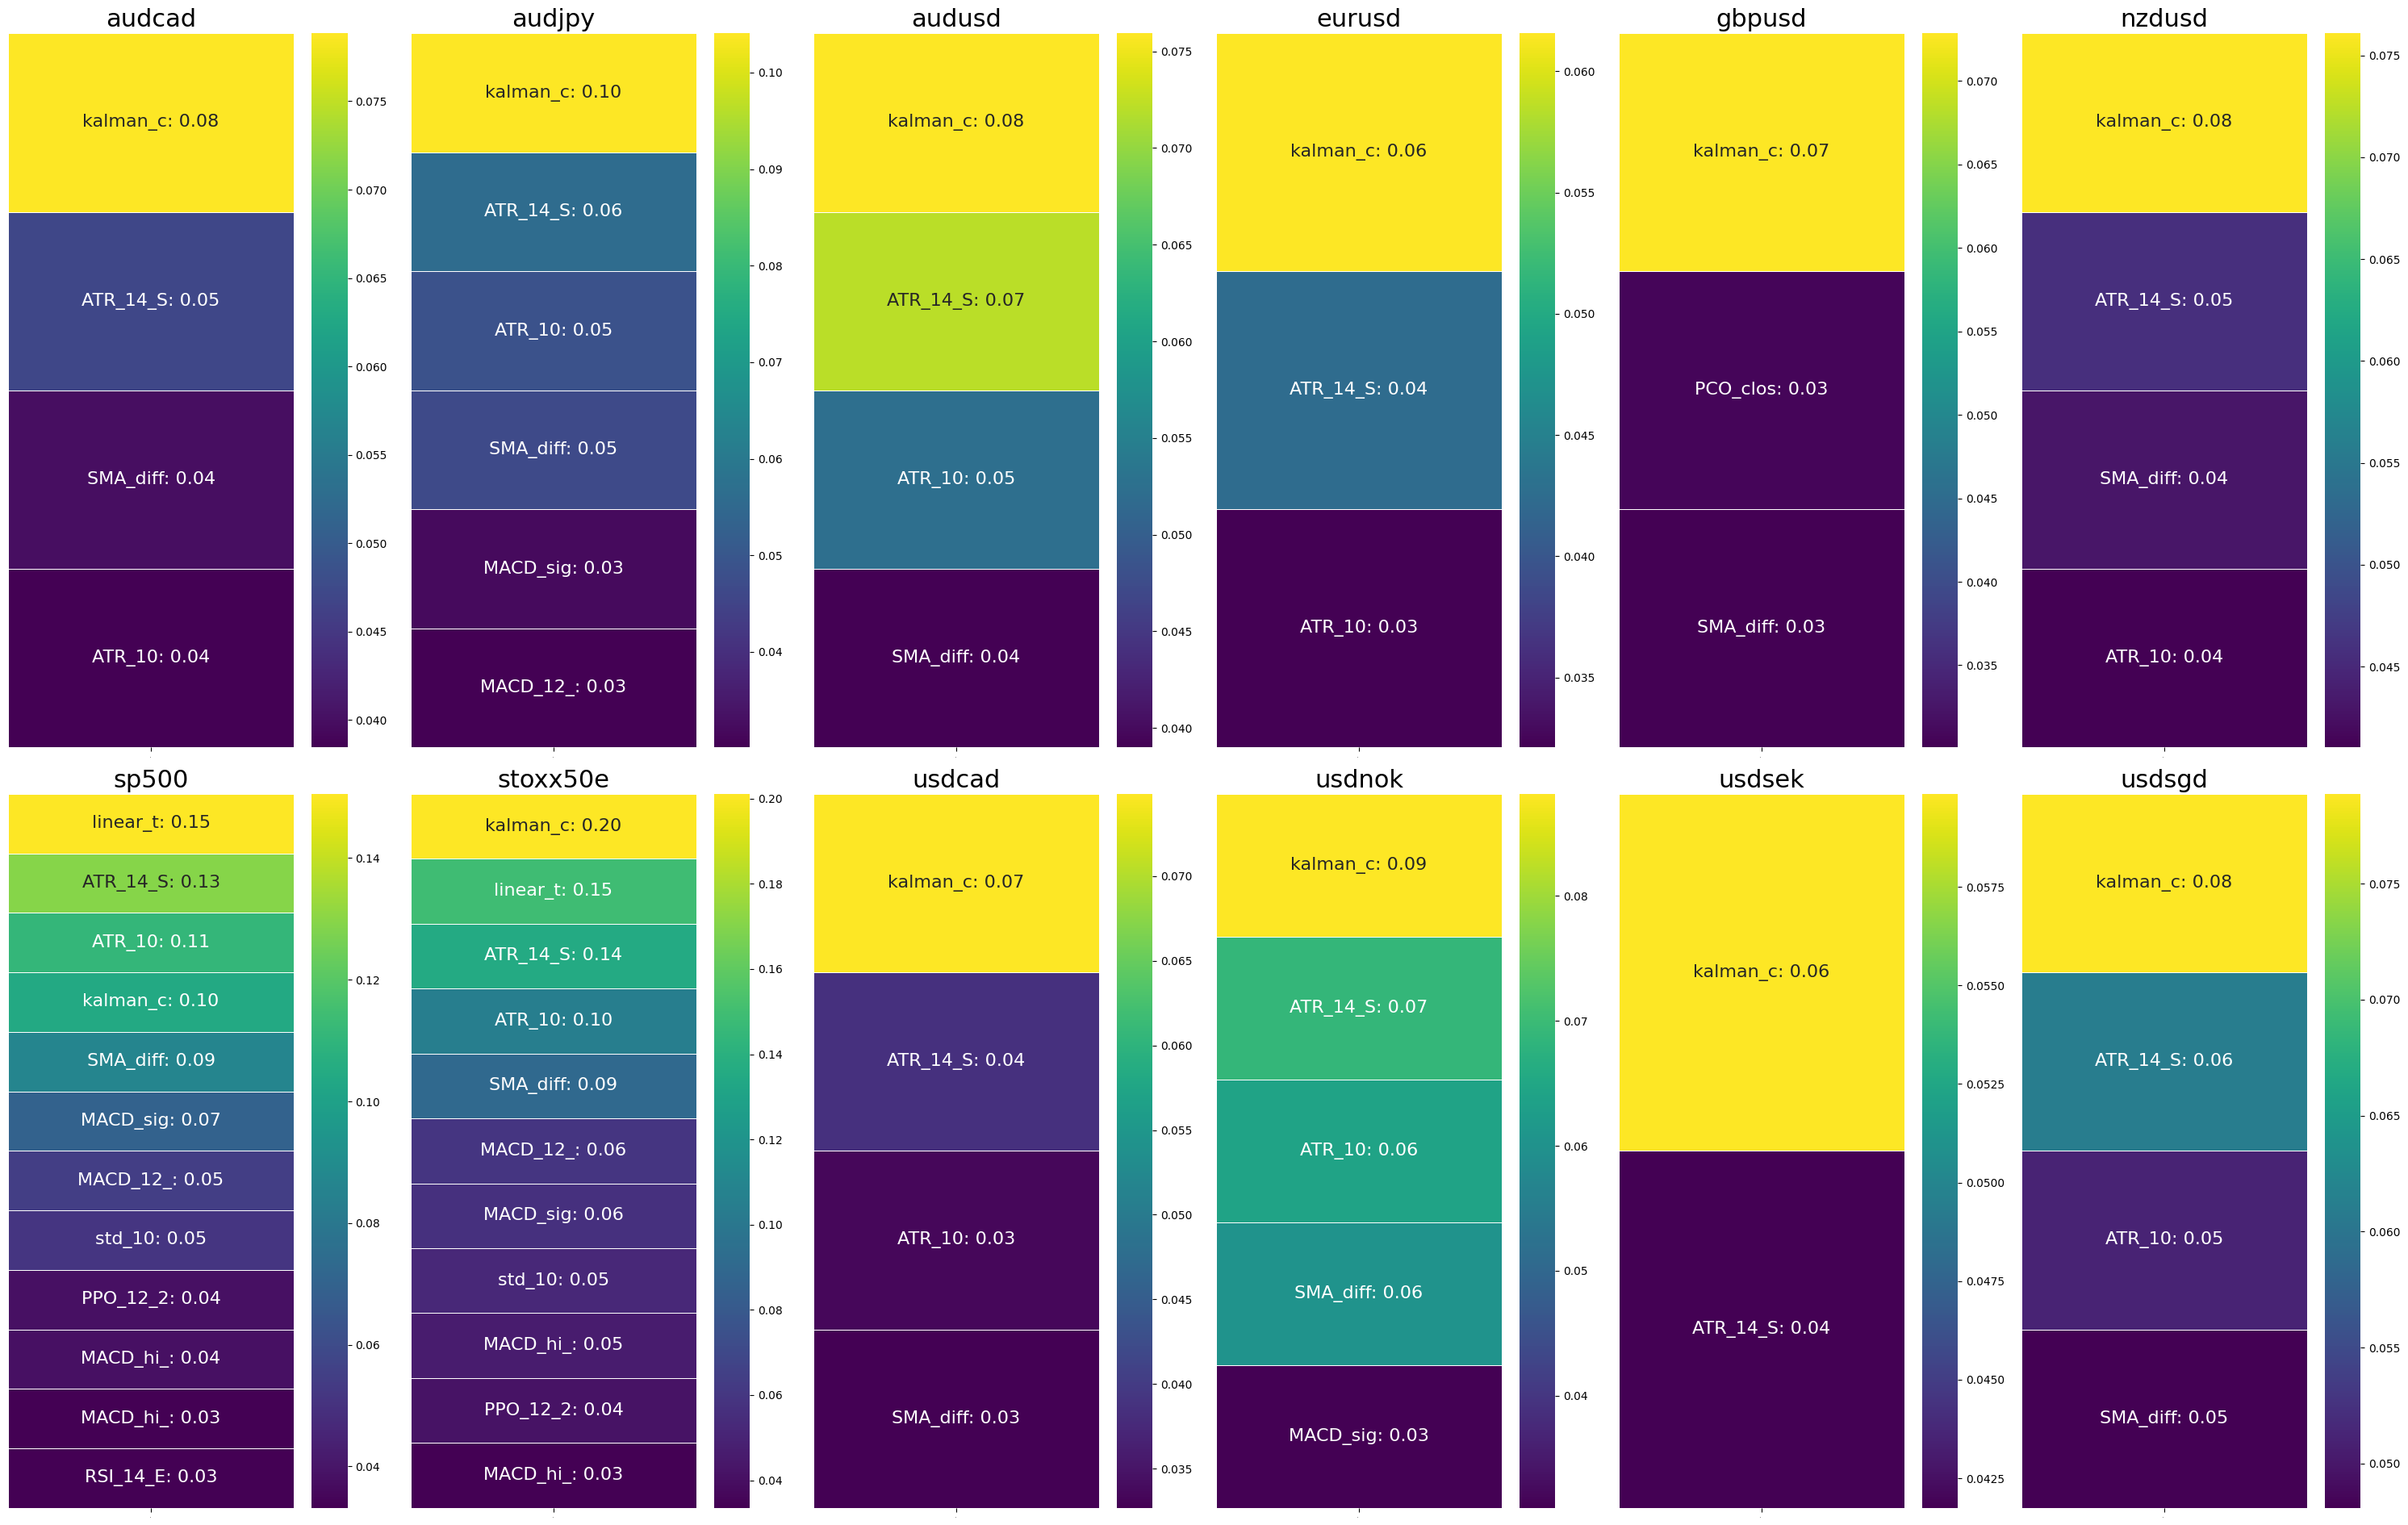

In [56]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

n_cols = 6  
n_pairs = len(ordered_keys)
n_rows = math.ceil(n_pairs / n_cols)

max_chars = 8  
threshold = 0.03  # Umbral mínimo de MI

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 0.5*len(list_X)*n_rows))
axes = axes.flatten() 

for i, key in enumerate(ordered_keys):
    df_copy = train_dataframes[key][list_X + [col_y]].dropna()
    X = df_copy[list_X].iloc[:-1, :]
    y = df_copy[col_y].iloc[1:]
    
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)
    mi_series = pd.Series(mi, index=list_X).sort_values(ascending=False)
    
    # Filtrar solo las features con MI > threshold
    mi_series = mi_series[mi_series > threshold]
    
    if len(mi_series) > 0:
        heatmap_df = mi_series.to_frame(name='MI')
        
        # Versión con nombres recortados
        heatmap_df_short = heatmap_df.copy()
        heatmap_df_short.index = [idx[:max_chars] for idx in heatmap_df.index]
        
        # Anotaciones con nombres recortados
        annot = [[f"{idx[:max_chars]}: {val:.2f}"] for idx, val in zip(heatmap_df.index, heatmap_df['MI'])]
        
        sns.heatmap(
            heatmap_df_short, 
            annot=annot, 
            fmt='', 
            cmap='viridis', 
            cbar=True, 
            linewidths=0.5, 
            ax=axes[i],
            annot_kws={"size": 16}
        )
        axes[i].set_title(key, fontsize=22)
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([])
        axes[i].tick_params(axis='y', left=False)
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=90, labelsize=1)
    else:
        # Si ninguna feature pasa el umbral, borramos ese subplot
        fig.delaxes(axes[i])

# Si hay subplots vacíos, los eliminamos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Información mutua de todas las features:
kalman_close_10           0.088161
ATR_14_SMA_10             0.068850
ATR_10                    0.064238
SMA_diff                  0.060328
MACD_signal_9             0.031029
MACD_12_26                0.027974
std_10                    0.024401
MACD_hi_12_26_9_EMA_10    0.020785
MACD_hi_12_26_9           0.018694
PCO_close                 0.017021
PPO_12_26                 0.013052
CMMA_10                   0.011236
STK_10                    0.010595
STO_RSI_D_14              0.005316
RSI_14_EMA_10             0.004716
STO_RSI_K_14              0.002602
linear_trend_10           0.002195
RSI_14                    0.001796
STO_RSI_14                0.000000
dtype: float64

Features seleccionadas:
['kalman_close_10', 'ATR_14_SMA_10', 'ATR_10', 'SMA_diff']


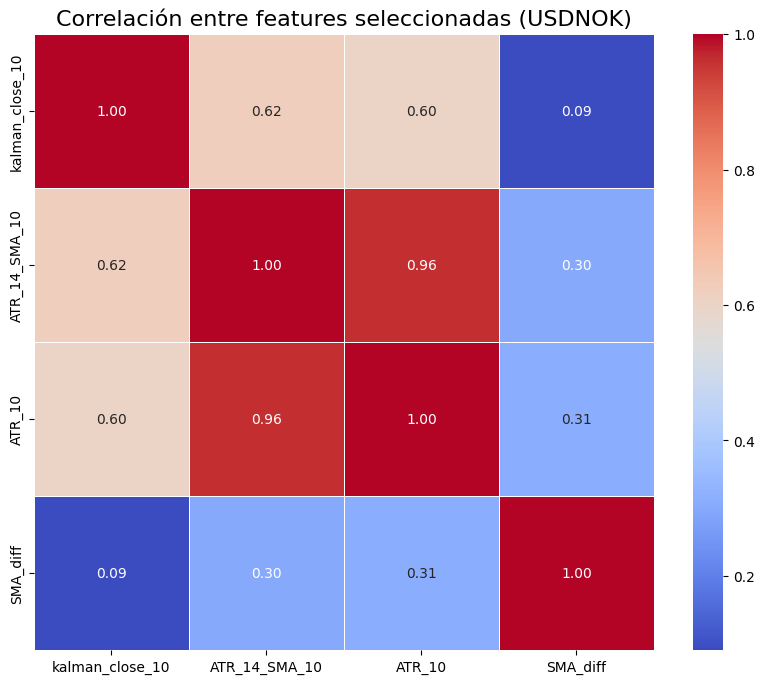

In [67]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mutual_info_single_pair(df, features, target='fut_ret_10', threshold=0.09):
    df_copy = df[features + [target]].dropna()
    
    X = df_copy[features].iloc[:-1, :]
    y = df_copy[target].iloc[1:]
    
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)
    mi_series = pd.Series(mi, index=features).sort_values(ascending=False)
    
    selected_features = mi_series[mi_series > threshold].index.tolist()
    
    return mi_series, selected_features

# Ejemplo de uso para un único pair
pair = 'USDNOK'
df_pair = train_dataframes[pair.lower()]  # DataFrame limpio con features
mi_series, selected_features = mutual_info_single_pair(df_pair, list_X, threshold=0.05)

print("Información mutua de todas las features:")
print(mi_series)
print("\nFeatures seleccionadas:")
print(selected_features)

# ----------------------------
# Calcular la correlación entre las features seleccionadas
# ----------------------------
df_selected = df_pair[selected_features].dropna()
correlation_matrix = df_selected.corr()

# Opcional: visualizar la correlación con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title(f"Correlación entre features seleccionadas ({pair})", fontsize=16)
plt.show()